In [1]:
%matplotlib inline

import os 
import warnings
import matplotlib as mpl

# Set default figure size 
mpl.rcParams['figure.figsize'] = [9.0, 6.0]

# Ignore warnings 
warnings.simplefilter("ignore")

# Location of the data directory on disk 
DATA = "data"

# Session 2: Information Extraction 
**June 21, 2018** 

In this session, we will take a deeper dive into the language processing toolkit to find ways to automatically extract and parse information from text. 

In the first session, we looked at ways of breaking down text into its constituent parts: documents into paragraphs, paragraphs into sentences, and sentences into token, tag tuples. We discovered that this data wrangling is the basis for discovering meaning in text through statistical techniques. For example, we explored the use of N-Gram analysis to find significant collocations. 

Text data contains a lot more information than simple collocations of words, such as parts-of-speech (e.g. what's a noun, a verb, and adjective, etc.). We can use linguistic information to start to build more complex data structures that will enable more effective parsing of text. We'll explore how to build syntax parses using NLTK, Stanford and spaCy to find dependencies between words that imply significant relationships. We will then use this information to summarize text, extract key phrases, and find named entities of interest. We can then link these entities together in a graph data structure, then use graph analysis techniques to find significant entities and their relationships. 

## Syntactic Parsing 

Assigning a structure to a sentence that reveals relationships governed by syntax rules, e.g. by grammars. Consider the sentence:

> The factory employs 12.8 percent of Bradford County.  

Syntax parses produce a tree that will enable us to understand that the subject of this sentence is "the factory", the predicate is "employs", and that the target is "12.8 percent", which in turn is modified by "Bradford County". 

### Syntax Parsing Challenges

Before we turn to how we conduct syntax parsing, we should note that parsing is a challenge, primarily because of **structural ambiguity**. Parsing, therefore is a stochastic machine learning technique that requires a lot of computational power.

While it is possible to develop a parser of your own in pure Python with NLTK (we'll explore some of this later). The libraries that exist to do this are generally black boxes. We'll look at two toolkits:

1. Stanford CoreNLP (with NLTK wrapper)
2. spaCy (dependency parsing only) 

![Constituency Parse](figures/s2_constituency_parsing.jpg)

A parse tree that distinguishes between terminal (phrases) and non-terminal (parts-of-speech) elements. Usually _deep_ and contain large amounts of _extra information_. 

![Dependency Parse](figures/s2_dependency_parsing.jpg)

Does not acknowledge difference between terminal (phrases) and non-terminal (parts-of-speech) elements. However, they are _simpler_ than constituency-based parse trees. 

### Stanford CoreNLP 

The Stanford CoreNLP package is written in Java 1.8 and contains one of the most advanced parsers for English, Arabic, Chinese, French, German, and Spanish. From Python, we can use CoreNLP by downloading the `.jar` files from [Stanford NLP download page](https://stanfordnlp.github.io/CoreNLP/#download) and wrapping the API servers that the JAR exposes with requests from NLTK.

> **NOTE**: If you don't have Java 1.8 installed or cannot download the CoreNLP packages, I would recommend skipping ahead to the Dependency Parsing section and using spaCy for parses. Not only is this pure Python, but it is more likely what you'll be using for parse analysis as well as machine learning. 

In [2]:
# Starting the CoreNLPServer 
from nltk.parse.corenlp import CoreNLPServer 

# The server needs to know the location of the following files:
#   - stanford-corenlp-X.X.X.jar 
#   - stanford-corenlp-X.X.X-models.jar 
STANFORD = os.path.join(DATA, "stanford-corenlp-full-2018-02-27")

# Create the server 
server = CoreNLPServer(
    os.path.join(STANFORD, "stanford-corenlp-3.9.1.jar"),
    os.path.join(STANFORD, "stanford-corenlp-3.9.1-models.jar"),    
)

# Start the server in the background 
server.start()

In [3]:
from nltk.parse.corenlp import CoreNLPParser 

parser = CoreNLPParser()
parse = next(parser.raw_parse("I put the book in the box on the table."))

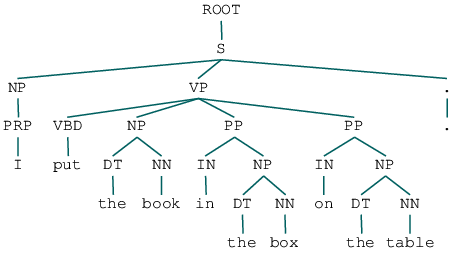

In [4]:
parse

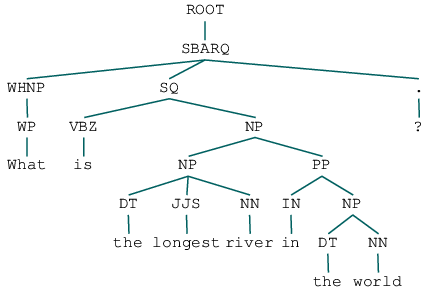

In [5]:
next(parser.raw_parse("What is the longest river in the world?"))

In [6]:
from nltk.parse.corenlp import CoreNLPDependencyParser 

parser = CoreNLPDependencyParser()
parse = next(parser.raw_parse("I put the book in the box on the table."))

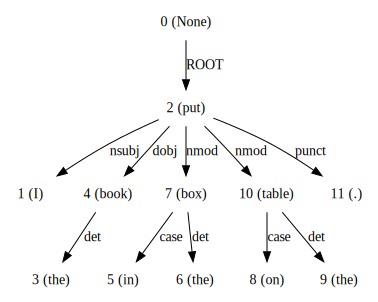

In [7]:
parse

In [8]:
# Stop the CoreNLP server 
server.stop()

### spaCy

spaCy is "industrial-strength natural language processing" and is built for speed and performance, particularly information extraction from large amounts of data. It is written in Cython, so it still needs to be compiled and installed, but at least it is all Python. 

In [9]:
import spacy 
from spacy import displacy

# Load the english language models
# Required: python -m spacy download en 
EN = spacy.load("en")

In [10]:
# Parse and analyze the sentence/document 
doc = EN("The apple dropped not far from his head.")

# Draw the dependency tree into the notebook 
displacy.render(doc, style='dep', minify=True, jupyter=True)

## spaCy Preprocessing

While we're here; we can review how to perform some of the preprocessing tasks we explored with NLTK last week, this time using spaCy: 

- Segmentation 
- Tokenization 
- Part of Speech Tagging 

In [13]:
from utils.wapo import save_wapo, load_wapo

save_wapo("2JEisx5", category="sports")
doc = EN(load_wapo("2JEisx5"))
doc

 Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals. The area around Capital One Arena was packed for blocks in every direction; fans queued up in massive lines outside bars, restaurants, sandwich shops and liquor stores. They filled the G Street watch party between 7th and 9th Streets hours before the Washington Capitals began their quest to clinch their first Stanley Cup. Meanwhile, thousands poured into a different watch party inside the arena. Inside the arena, fans roared during every pregame clip of the Capitals, roared during every near miss, roared during the first intermission when Caps broadcasters led a round of “Let’s Go Caps!” chants. When Washington killed a second-period power play, the noise inside the arena was earsplitting. When Jakub Vrana scored on a breakaway moments later, the noise was … what’s louder than ear-splitting? VIDEO CELEBRATIONS | CELEBRITIES AND FORMER CA

In [18]:
sents = list(doc.sents)
print(len(sents))
print(sents[0])
print(sents[14])

166
 Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals.
Chuck Brown’s “Bustin’ Loose” blared through the speaker system.


In [22]:
tokens = list(doc)
print(len(tokens))
print(tokens[12])

2134
turned


In [26]:
from tabulate import tabulate 

table = [["Text", "Lemma", "POS", "Tag", "Dep", "Alpha", "Stop"]]
for token in doc[:20]:
    table.append([
        token.text, token.lemma_, token.pos_, token.tag_, 
        token.dep_, token.is_alpha, token.is_stop
    ])
print(tabulate(table, tablefmt="simple", headers="firstrow"))

Text           Lemma          POS    Tag    Dep       Alpha    Stop
-------------  -------------  -----  -----  --------  -------  ------
                              SPACE                   False    False
Downtown       downtown       PROPN  NNP    compound  True     False
Washington     washington     PROPN  NNP    nsubj     True     False
turned         turn           VERB   VBD    ROOT      True     False
red            red            ADJ    JJ     acomp     True     False
Thursday       thursday       PROPN  NNP    compound  True     False
afternoon      afternoon      NOUN   NN     npadvmod  True     False
and            and            CCONJ  CC     cc        True     True
evening        evening        NOUN   NN     conj      True     False
,              ,              PUNCT  ,      punct     False    False
as             as             ADP    IN     mark      True     True
fans           fan            NOUN   NNS    nsubj     True     False
turned         turn           VERB  